In [ ]:
#Setting up and Imports
# Step 1: Mount Google Drive and install core dependency (imbalanced-learn) ---



from google.colab import drive
drive.flush_and_unmount()         # unmount if already mounted
!rm -rf /content/drive            # clear old directory handle
drive.mount('/content/drive', force_remount=True)

# (Optional) install if needed
!pip -q install imbalanced-learn==0.12.3


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.0 MB/s eta 0:00:00


In [ ]:
# We remount Drive to ensure a clean handle, then install imbalanced-learn (used for ADASYN/ROS and pipelines).
# This cell also imports all foundational Python, imaging, deep-learning, and scikit-learn utilities used later.
import os, random, numpy as np
import matplotlib.pyplot as plt

import cv2 as cv
from PIL import Image
import imagehash
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input


from sklearn.model_selection import (
    GroupShuffleSplit,                # group-exclusive split (prevents near-dup leakage)
    StratifiedKFold,                  # inner CV for grid-search
    GridSearchCV
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_curve, auc,
    ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score
)

# Imbalanced learning (oversampling INSIDE CV)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN, RandomOverSampler



In [ ]:
# Step 2: Define dataset roots and list all images recursively
melasma_dir = '/content/drive/MyDrive/original_melasma'
others_dir  = '/content/drive/MyDrive/og_nonmelasma'

from pathlib import Path

def collect_images(root):
    exts = {
        '.jpg','.jpeg','.png','.bmp','.webp',
        '.tif','.tiff','.gif','.jfif','.pjpeg','.pjp','.JPG','.JPEG','.PNG'
    }
    root = Path(root)
    if not root.exists():
        print(f"[!] Missing folder: {root}")
        return []
    # recursive, case-insensitive via suffix.lower()
    return [str(p) for p in root.rglob('*') if p.suffix.lower() in {e.lower() for e in exts}]

melasma_paths = sorted(collect_images(melasma_dir))
others_paths  = sorted(collect_images(others_dir))

X_paths = melasma_paths + others_paths
y       = np.array([1]*len(melasma_paths) + [0]*len(others_paths))  # 1=Melasma, 0=Others

print(f"#Melasma={len(melasma_paths)}  #Others={len(others_paths)}  #Total={len(X_paths)}")
print("Sample Melasma:", melasma_paths[:3])
print("Sample Others :", others_paths[:3])


#Melasma=30  #Others=33  #Total=63
Sample Melasma: ['/content/drive/MyDrive/original_melasma/Image10_result_result.png', '/content/drive/MyDrive/original_melasma/Image11_result_result.png', '/content/drive/MyDrive/original_melasma/Image12_result_result.png']
Sample Others : ['/content/drive/MyDrive/og_nonmelasma/Lichenplanuspigmentosis2.JPG', '/content/drive/MyDrive/og_nonmelasma/Lichenplanuspigmentosis3.JPG', '/content/drive/MyDrive/og_nonmelasma/Lichenplanuspigmentosis4.JPG']


In [ ]:
# Step 3: Group near-duplicates using perceptual hashing (pHash) ---
# phash_groups() assigns a group ID to visually similar images via Hamming distance on pHash.
# Group IDs let us do group-exclusive splitting so near-duplicates don't leak from train into test.
# Tweak distance_thresh to be stricter/looser for grouping (smaller = stricter).

def phash_groups(paths, hash_size=16, distance_thresh=4):

    N = len(paths)
    phashes = []
    for p in paths:
        try:
            with Image.open(p) as im:
                phashes.append(imagehash.phash(im.convert('RGB'), hash_size=hash_size))
        except Exception:
            phashes.append(None)

    groups = [-1]*N
    gid = 0
    for i in range(N):
        if groups[i] != -1:
            continue
        groups[i] = gid
        if phashes[i] is None:
            gid += 1
            continue
        for j in range(i+1, N):
            if groups[j] != -1 or phashes[j] is None:
                continue
            if (phashes[i] - phashes[j]) <= distance_thresh:
                groups[j] = gid
        gid += 1
    return np.array(groups, dtype=int)

groups = phash_groups(X_paths, hash_size=16, distance_thresh=4)
print("Unique groups:", len(np.unique(groups)))


Unique groups: 63


In [ ]:
# Step 4: Load VGG16 (ImageNet) as a fixed feature extractor ---
# We load a pretrained VGG16 (without top) with global average pooling.
# extract_vgg16_features() preprocesses images, runs them through VGG, and returns 512-D embeddings.
# This yields X_all (features), y_all (labels), and groups_all (duplicate groups)

vgg = VGG16(weights='imagenet', include_top=False, pooling='avg')

def extract_vgg16_features(paths, batch=32):
    feats = []
    for i in range(0, len(paths), batch):
        batch_paths = paths[i:i+batch]
        imgs = []
        for p in batch_paths:
            img = cv.imread(p)           # BGR
            if img is None:
                print(f"[warn] unreadable image skipped: {p}")
                continue
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (224, 224))
            imgs.append(img)
        if not imgs:
            continue
        arr = np.array(imgs, dtype=np.float32)
        arr = preprocess_input(arr)
        f   = vgg.predict(arr, verbose=0)   # (B, 512)
        feats.append(f)
    if not feats:
        return np.empty((0, 512), dtype=np.float32)
    return np.vstack(feats).astype(np.float32)


In [ ]:
X_all      = extract_vgg16_features(X_paths)
y_all      = y.copy()
groups_all = groups.copy()

print("Features:", X_all.shape, " labels:", y_all.shape, " groups:", groups_all.shape)
print("Class counts (0=Others,1=Melasma):", np.bincount(y_all))


Features: (63, 512)  labels: (63,)  groups: (63,)
Class counts (0=Others,1=Melasma): [33 30]


In [ ]:
# Step 5: Train/validation split with group exclusivity ---
# Used GroupShuffleSplit to create a test split that is group-exclusive (no near-duplicate leakage).
# Keep train groups (groups_tr) for potential nested CV if needed (not required for this pipeline).
# This prints class balance in each split to check for severe imbalance.

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
tr_idx, te_idx = next(gss.split(X_all, y_all, groups=groups_all))

X_tr, X_te = X_all[tr_idx], X_all[te_idx]
y_tr, y_te = y_all[tr_idx], y_all[te_idx]
groups_tr   = groups_all[tr_idx]

print("Train:", X_tr.shape, " Test:", X_te.shape)
print("Train counts:", np.bincount(y_tr), "  Test counts:", np.bincount(y_te))


Train: (50, 512)  Test: (13, 512)
Train counts: [26 24]   Test counts: [7 6]


In [ ]:
# Step 6: Build imbalanced-learn Pipeline and hyperparameter grid
# We define a Pipeline with an oversampler (ADASYN/RandomOverSampler) followed by a DecisionTreeClassifier.
# Two search branches:
#   (A) Oversampling + DT hyperparams
#   (B) No oversampling but class_weight='balanced'
# The grid searches common DT knobs: criterion, depth, min samples, and cost-complexity pruning (ccp_alpha).

samplers = [
    ADASYN(random_state=42, n_neighbors=3),
    RandomOverSampler(random_state=42),
    'passthrough'  # no sampler
]

pipe = Pipeline([
    ('sampler', 'passthrough'),
    ('clf', DecisionTreeClassifier(random_state=42))
])

param_grid = [
    # Oversampling + plain DT
    {
        'sampler': samplers[:-1],  # ADASYN or ROS
        'clf__criterion': ['gini', 'entropy', 'log_loss'],
        'clf__max_depth': [None, 5, 10, 20, 40],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__ccp_alpha': [0.0, 0.001, 0.01],
    },
    # No oversampling + class_weight balanced
    {
        'sampler': ['passthrough'],
        'clf__criterion': ['gini', 'entropy', 'log_loss'],
        'clf__max_depth': [None, 5, 10, 20, 40],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__ccp_alpha': [0.0, 0.001, 0.01],
        'clf__class_weight': ['balanced'],
    }
]
# Step 7: Inner cross-validation grid-search (model selection) ---
# StratifiedKFold maintains label balance across folds.
# GridSearchCV explores the param_grid with scoring='f1' (robust on imbalance) and parallel jobs.
# Fit on the TRAIN split only; best_pipe becomes the tuned pipeline (sampler + decision tree).

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(
    pipe, param_grid,
    scoring='f1', cv=inner_cv, n_jobs=-1, verbose=1, error_score=np.nan
)
gs.fit(X_tr, y_tr)
best_pipe = gs.best_estimator_
print("Best params:", gs.best_params_)


Fitting 5 folds for each of 1215 candidates, totalling 6075 fits
Best params: {'clf__ccp_alpha': 0.0, 'clf__class_weight': 'balanced', 'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'sampler': 'passthrough'}


              precision    recall  f1-score   support

      Others       1.00      0.71      0.83         7
     Melasma       0.75      1.00      0.86         6

    accuracy                           0.85        13
   macro avg       0.88      0.86      0.85        13
weighted avg       0.88      0.85      0.84        13



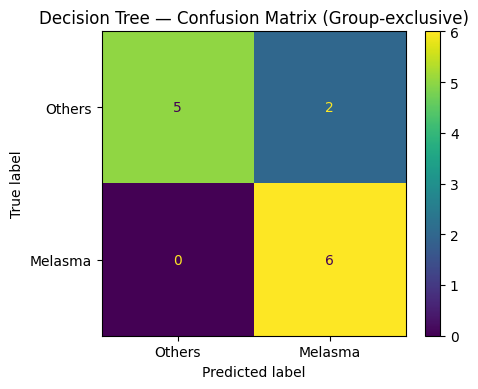

ROC-AUC: 0.8571428571428572


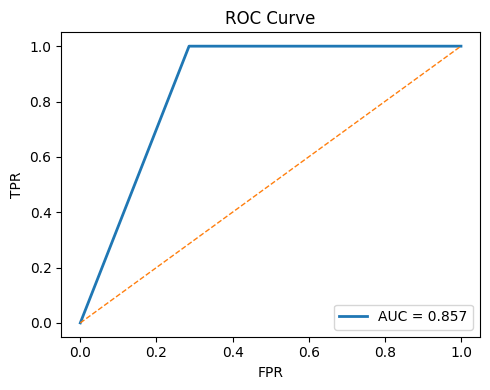

In [ ]:
# Step 8: Final evaluation on the held-out TEST split
# Used best_pipe to predict labels and (if available) probabilities on X_te.
# Report: classification report (per-class precision/recall/F1), confusion matrix, ROC curve and ROC-AUC.


y_pred = best_pipe.predict(X_te)
# guard for predict_proba availability
try:
    y_prob = best_pipe.predict_proba(X_te)[:, 1]
except Exception:
    y_prob = y_pred.astype(float)

print(classification_report(y_te, y_pred, target_names=["Others","Melasma"]))

cm = confusion_matrix(y_te, y_pred, labels=[0,1])
fig, ax = plt.subplots(figsize=(5,4))
ConfusionMatrixDisplay(cm, display_labels=["Others","Melasma"]).plot(ax=ax)
plt.title("Decision Tree — Confusion Matrix (Group-exclusive)")
plt.tight_layout(); plt.show()

fpr, tpr, _ = roc_curve(y_te, y_prob)
print("ROC-AUC:", auc(fpr, tpr))
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()


Melasma samples:


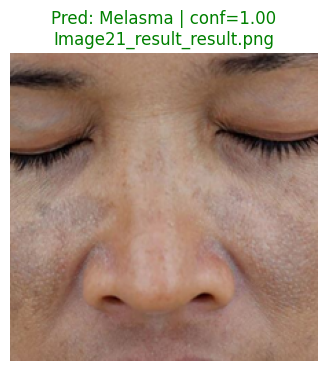

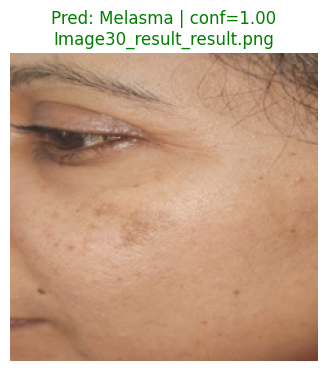

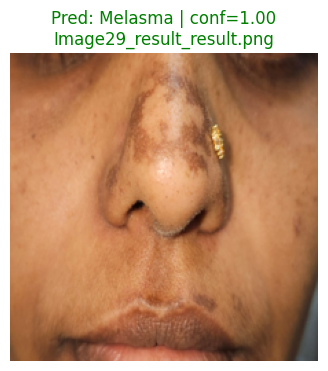

Others samples:


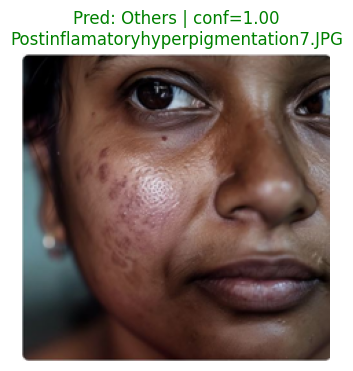

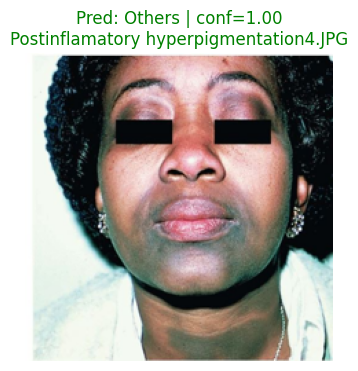

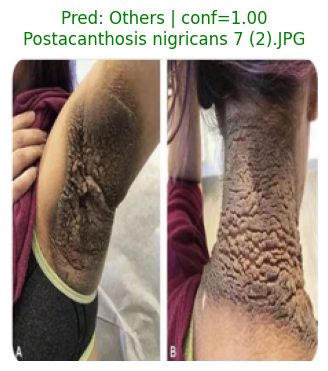

In [ ]:
#Some examples of classified and misclassified images
def predict_one_img_path(path, vgg, clf):
    img = Image.open(path).convert('RGB').resize((224,224))
    arr = np.array(img, dtype=np.float32)[None, ...]
    arr = preprocess_input(arr)
    feat = vgg.predict(arr, verbose=0)
    # predict_proba guard
    prob1 = clf.predict_proba(feat)[0,1] if hasattr(clf, "predict_proba") else float(clf.predict(feat)[0])
    pred  = int(prob1 >= 0.5)
    return pred, prob1, img

def show_preds(paths, true_label=None, k=4):
    picks = paths if len(paths) <= k else random.sample(paths, k)
    for p in picks:
        pred, prob1, img = predict_one_img_path(p, vgg, best_pipe)
        label = "Melasma" if pred==1 else "Others"
        conf  = prob1 if pred==1 else (1.0 - prob1)
        plt.figure(figsize=(4,4))
        plt.imshow(img); plt.axis('off')
        color = "black" if true_label is None else ("green" if pred==true_label else "red")
        plt.title(f"Pred: {label} | conf={conf:.2f}\n{os.path.basename(p)}", color=color)
        plt.show()

print("Melasma samples:")
show_preds(melasma_paths, true_label=1, k=3)
print("Others samples:")
show_preds(others_paths,  true_label=0, k=3)
